In [82]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time

from tqdm import tqdm

In [83]:
def circle_points_torch(radius, num_points):
    """
    Generate coordinates of points on the circumference of a circle using PyTorch.

    Parameters:
    radius (float): The radius of the circle.
    num_points (int): The number of points to generate on the circumference.

    Returns:
    torch.Tensor: A tensor of shape (num_points, 2) containing the coordinates of the points.
    """
    # Create a tensor of angles evenly spaced around the circle
    angles = torch.linspace(0, 2 * torch.pi, num_points)
    
    # Calculate the x and y coordinates for each point
    x = radius * torch.cos(angles)
    y = radius * torch.sin(angles)
    norm= torch.sqrt( x**2 + y**2 )
    n_x = x / norm
    n_y = y / norm
    points = torch.stack((x, y,-n_x,-n_y), dim=1)
    return points

def circle_points_inverse_torch(radius, num_points):
    """
    Generate coordinates of points on the circumference of a circle using PyTorch.

    Parameters:
    radius (float): The radius of the circle.
    num_points (int): The number of points to generate on the circumference.

    Returns:
    torch.Tensor: A tensor of shape (num_points, 2) containing the coordinates of the points.
    """
    # Create a tensor of angles evenly spaced around the circle
    angles = torch.linspace(0, 2 * torch.pi, num_points)
    
    # Calculate the x and y coordinates for each point
    x = radius * torch.cos(angles)
    y = radius * torch.sin(angles)
    norm= torch.sqrt( x**2 + y**2 )
    n_x = x / norm
    n_y = y / norm
    points = torch.stack((x, y,n_x,n_y), dim=1)
    return points

def draw_p(l):
    for elem in l:
        plt.scatter(elem[0],elem[1],color="black")

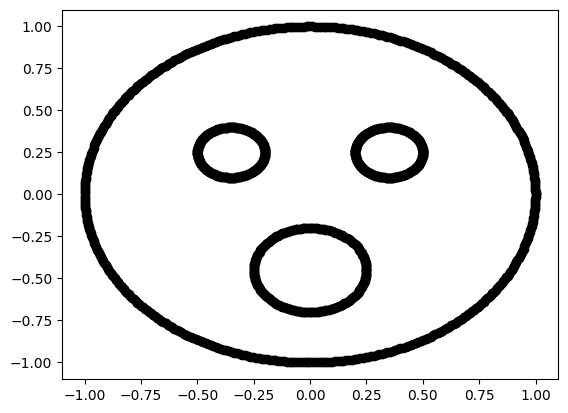

In [84]:
points_ext=circle_points_torch(radius=1,num_points=500)
points_eye_1=circle_points_inverse_torch(radius=0.15,num_points=200)
points_eye_2=circle_points_inverse_torch(radius=0.15,num_points=200)
points_eye_3=circle_points_inverse_torch(radius=0.25,num_points=200)

points_eye_1[:,0]-=0.35
points_eye_1[:,1]+=0.25

points_eye_2[:,0]+=0.35
points_eye_2[:,1]+=0.25


points_eye_3[:,1]-=0.45


points_c=torch.empty((points_ext.shape[0]+points_eye_1.shape[0]*3,4))

points_c[:points_ext.shape[0],:]=points_ext
points_c[points_ext.shape[0]:points_ext.shape[0]+points_eye_1.shape[0],:]=points_eye_1
points_c[points_ext.shape[0]+points_eye_1.shape[0]:points_ext.shape[0]+points_eye_1.shape[0]*2,:]=points_eye_2
points_c[points_ext.shape[0]+points_eye_1.shape[0]*2:,:]=points_eye_3

draw_p(points_c)

In [85]:
def get_borders(points):
    min_x=torch.min(points[:,0])
    max_x=torch.max(points[:,0])
    min_y=torch.min(points[:,1])
    max_y=torch.max(points[:,1])
    
    sep_x=torch.sqrt((max_x-min_x)**2)
    sep_y=torch.sqrt((max_y-min_y)**2)
    
    width=max(sep_x,sep_y)
    
    return (min_x,min_x+width,min_y,min_y+width)
    

def create_quadtree(dico,tmp_depth,depth,points,borders,label):
    min_x=borders[0]
    max_x=borders[1]
    min_y=borders[2]
    max_y=borders[3]
    
    sep_x=min_x+torch.sqrt((max_x-min_x)**2)/2.0
    sep_y=min_y+torch.sqrt((max_y-min_y)**2)/2.0
    
    
    
    
    mask=(points[:,0]<= sep_x) & (points[:,1]> sep_y)
    hg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]> sep_y)
    hd= points[mask]
    mask=(points[:,0]<= sep_x) & (points[:,1]<= sep_y)
    bg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]<= sep_y)
    bd= points[mask]
    
    
    gx=min_x
    gy=sep_y
    dx=sep_x
    dy=max_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"1"]=(tmp_depth,tmp_oc,dx-gx,border,hg)
    
    if (hg.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hg.clone(),border,label+"1")
    
    gx=sep_x
    gy=sep_y
    dx=max_x
    dy=max_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"2"]=(tmp_depth,tmp_oc,dx-gx,border,hd)
    
    if (hd.shape[0]>1)and depth>tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hd.clone(),border,label+"2")
    
    gx=min_x
    gy=min_y
    dx=sep_x
    dy=sep_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"3"]=(tmp_depth,tmp_oc,dx-gx,border,bg)
    
    
    if (bg.shape[0]>1)and depth>tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bg.clone(),border,label+"3")
    
    gx=sep_x
    gy=min_y
    dx=max_x
    dy=sep_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    

    dico[label+"4"]=(tmp_depth,tmp_oc,dx-gx,border,bd)
    
    
    if (bd.shape[0]>1) and depth>tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bd.clone(),border,label+"4")
    
    
    
    
def draw_quadtree(dico):
    fig = plt.figure()
    
    for node in dico:
        depth,_,_,border,l_points=dico[node]
        gx,dx,gy,dy=border
        
        
        if depth==1:
            draw_p(l_points)
        
        plt.plot([gx,dx],[gy,gy],color="blue")
        plt.plot([gx,dx],[dy,dy],color="blue")
        plt.plot([gx,gx],[dy,gy],color="blue")
        plt.plot([dx,dx],[dy,gy],color="blue")
    
    
    

In [86]:
dico=dict()
bord=get_borders(points_c)
create_quadtree(dico,1,11,points_c,bord,"")

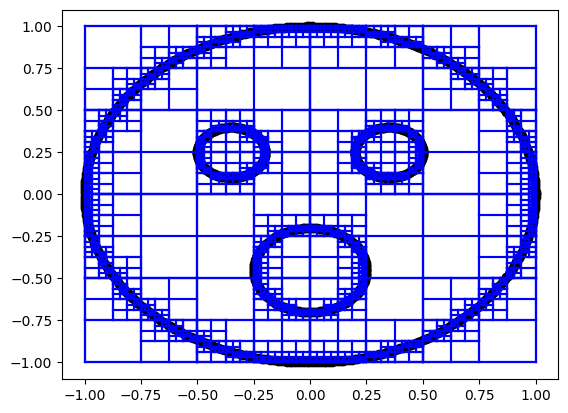

In [87]:
draw_quadtree(dico)

In [88]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        

s_p=points_c[:,:2]


def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,4))
    o_s=torch.ones((nb_s,4,4)) #interpolation weight , width , center
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,l_points=dico[node]
            
            for p in l_points:
                s_p[cpt_p]=p.clone()
                gx,dx,gy,dy=dico[node[:-1]][-2]

                tmp_o_vec=torch.empty((4,4))
                for idx_nbgr in range(1,5):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    

                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1 - u)*v
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1 - u)*(1 - v)
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1 - v)
                
                o_s[cpt_p]=tmp_o_vec.clone()
                cpt_p+=1
    return s_p,o_s
#s_p : (50,4)
#o_s : (50,4,3)

                
                
            
            
s_p,o_s=get_os(points_c.shape[0],dico,5)

#print(o_s.shape)

def get_alpha(s_p,o_s):
    #(100,4,2)
    tmp_mat_sp=torch.empty((o_s.shape[0],o_s.shape[1],o_s.shape[2]-1))
    tmp_mat_sp[:,0,:]=s_p[:,:2]
    tmp_mat_sp[:,1,:]=s_p[:,:2]
    tmp_mat_sp[:,2,:]=s_p[:,:2]
    tmp_mat_sp[:,3,:]=s_p[:,:2]

    #RMSE
    return torch.sum(torch.sqrt((tmp_mat_sp-o_s[:,:,:2])**2),dim=2)

def get_Fo(o_s,q):
    

    arg_f=tmp_mat_sp=torch.empty((o_s.shape[0],o_s.shape[1],o_s.shape[2]-1))
    tmp_mat_sp[:,0,:]=q.clone()
    tmp_mat_sp[:,1,:]=q.clone()
    tmp_mat_sp[:,2,:]=q.clone()
    tmp_mat_sp[:,3,:]=q.clone()
    
    w=o_s[:,:,2].view((o_s.shape[0],o_s.shape[1],1))
    
    
    tmp_mat_sp=(tmp_mat_sp-o_s[:,:,:2])/w
    
    tmp_mat_sp=torch.where(torch.abs(tmp_mat_sp)<0.5,1,0)
    
    tmp_mat_sp=torch.prod(tmp_mat_sp,dim=2)**3
    w=o_s[:,:,2].view((o_s.shape[0],o_s.shape[1]))
    
    return tmp_mat_sp*(1/w**3)  


D=10
l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V_q(q,l_o,l_s):
    q_vec=torch.empty((l_o.shape[0],4,2))
    q_vec[:,:,0]=q[0]
    q_vec[:,:,1]=q[1]
    
    q_vec[:,:,0]-=l_o[:,:,2]
    q_vec[:,:,0]/=l_o[:,:,1]
    q_vec[:,:,1]-=l_o[:,:,3]
    q_vec[:,:,1]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q_vec)**2,dim=2)/(2*(1.5**2)))
    #print(test.shape)
    
    
    test=test*l_o[:,:,0]
    
    res=torch.empty((l_o.shape[0],4,2))

   
    
    res[:,0]=l_s[:,2:]
    res[:,1]=l_s[:,2:]
    res[:,2]=l_s[:,2:]
    res[:,3]=l_s[:,2:]
    
    res[:,0,0]*=test[:,0]
    res[:,0,1]*=test[:,0]
    res[:,1,0]*=test[:,1]
    res[:,1,1]*=test[:,1]
    res[:,2,0]*=test[:,2]
    res[:,2,1]*=test[:,2]
    res[:,3,0]*=test[:,3]
    res[:,3,1]*=test[:,3]
    res=torch.sum(res,dim=(0,1))
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )
q=torch.ones(2)
q[0]=-1.
q[1]=0


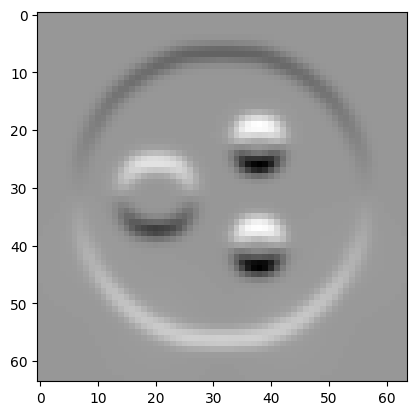

In [89]:
#octree depth
D=6
#grid resolution
n_p=64
#Average density for adaptative depth

min_x=bord[0].item()
max_x=bord[1].item()
min_y=bord[2].item()
max_y=bord[3].item()

width_x=max_x-min_x
width_y=max_y-min_y

image_res=torch.zeros((n_p,n_p,2))
vec=torch.linspace(min_x-width_x*0.125,max_x+width_x*0.125,n_p)


s_p=points_c[:,:2]
l_s,l_o=get_os(s_p.shape[0],dico,D)



for i in range(len(vec)):
    for j in range(len(vec)):
        coords=torch.empty(2)
        coords[0]=vec[i]
        coords[1]=vec[j]
        tmp=get_V_q(coords,l_o,l_s)
        image_res[i][j]=tmp

plt.imshow(torch.sqrt(image_res[:,:,0]**2+image_res[:,:,1]**2),cmap="Greys")
plt.imshow(image_res[:,:,0],cmap="Greys")

In [90]:
def compute_divergence(V):
    # Initialize the divergence tensor with the same spatial dimensions, but only one channel
    div_V = torch.zeros((V.shape[0], V.shape[1]))
    
    # Compute the x-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[1:-1, :] += (V[2:, :, 0] - V[:-2, :, 0]) / 2
    
    # Compute the y-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[:, 1:-1] += (V[:, 2:, 1] - V[:, :-2, 1]) / 2
    
    # Handle the borders if necessary (here we assume a zero-gradient boundary condition)
    # This can be replaced with a more appropriate condition for your specific case
    div_V[0, :] += (V[1, :, 0] - V[0, :, 0])
    div_V[-1, :] += (V[-1, :, 0] - V[-2, :, 0])
    div_V[:, 0] += (V[:, 1, 1] - V[:, 0, 1])
    div_V[:, -1] += (V[:, -1, 1] - V[:, -2, 1])

    return div_V


In [91]:


def get_list_gaussians(borders,D):
    res_centers=torch.empty(4**D,3)
    borders=bord#get_borders(points_c)

    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()

    Width=(max_x-min_x)/(2**D)
    cpt_idx=0

    for i in range(2**D):
        for j in range(2**D):
            
            xa=min_x+(i*Width)+Width/2.0
            ya=min_y+(j*Width)+Width/2.0
    
            res_centers[cpt_idx,0]=xa
            res_centers[cpt_idx,1]=ya
            res_centers[cpt_idx,2]=Width
            
            cpt_idx+=1
    return res_centers

In [102]:
L_gaussians=get_list_gaussians(bord,5)
#plt.scatter(L_gaussians[:,0],L_gaussians[:,1])
#plt.xlim([-1, 1])
#plt.ylim([-1, 1])

In [103]:
def get_inner_product_gradVB(V,L_gaussians,borders):
    res=torch.empty(L_gaussians.shape[0])

    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()

    xs = torch.linspace(min_x, max_x, steps=V.shape[0])
    ys = torch.linspace(min_y, max_x, steps=V.shape[0])
    
    
    x, y = torch.meshgrid(xs, ys, indexing='ij')

    grid=torch.empty(V.shape[0],V.shape[0],2)
    grid[:,:,0]=x
    grid[:,:,1]=y

    
    


    for idx_gaussian in range(L_gaussians.shape[0]):
        tmp_res=grid.clone()
        tmp_res=(tmp_res[:,:,0]-L_gaussians[idx_gaussian,0])**2+(tmp_res[:,:,1]-L_gaussians[idx_gaussian,1])**2
        tmp_res=torch.exp(-(tmp_res/(2*L_gaussians[idx_gaussian,2]**2)))
        
        tmp_res=tmp_res*V*(2*L_gaussians[idx_gaussian,2]**2)
        tmp_res=torch.sum(tmp_res)
        res[idx_gaussian]=tmp_res
        
    
    
        
    return res

In [104]:
V_o=get_inner_product_gradVB(grad,L_gaussians,bord)

torch.Size([1024])


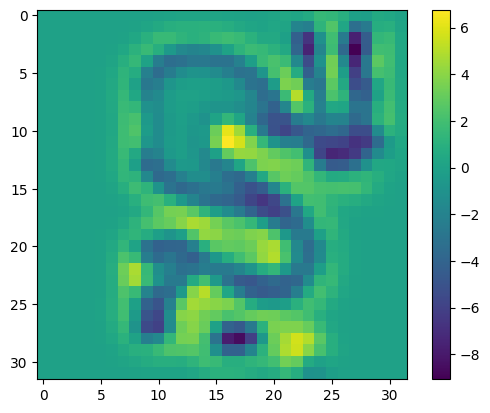

In [105]:
print(V_o.shape)

plt.imshow(V_o.reshape((np.uint(np.sqrt(V_o.shape[0])),np.uint(np.sqrt(V_o.shape[0])))))
plt.colorbar()

In [106]:
def get_inner_product_gradB_B(size_grid,L_gaussians,borders):
    res=torch.zeros((L_gaussians.shape[0],L_gaussians.shape[0]))

    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()

    width_x=max_x-min_x
    width_y=max_y-min_y

    xs = torch.linspace(min_x-width_x*0.125, max_x+width_x*0.125, steps=size_grid)
    ys = torch.linspace(min_y-width_y*0.125, max_y+width_y*0.125, steps=size_grid)
    
    
    x, y = torch.meshgrid(xs, ys, indexing='xy')

    grid=torch.empty(size_grid,size_grid,2)
    grid[:,:,0]=x
    grid[:,:,1]=y
    
    


    for idx_gaussian_1 in range(L_gaussians.shape[0]):
        print(idx_gaussian_1)
        for idx_gaussian_2 in range(idx_gaussian_1,L_gaussians.shape[0]):
            tmp_g1=grid.clone()
            
            tmp_g1=torch.exp(-((tmp_g1[:,:,0]-L_gaussians[idx_gaussian_1,0])**2+(tmp_g1[:,:,1]-L_gaussians[idx_gaussian_1,1])**2)/(2*L_gaussians[idx_gaussian_1,2]**2))

            
            tmp_g2=grid.clone()
            fac_x=((tmp_g2[:,:,0]-L_gaussians[idx_gaussian_2,0])**2-(L_gaussians[idx_gaussian_2,2]**2))/(L_gaussians[idx_gaussian_2,2]**4)
            fac_y=((tmp_g2[:,:,1]-L_gaussians[idx_gaussian_2,1])**2-(L_gaussians[idx_gaussian_2,2]**2))/(L_gaussians[idx_gaussian_2,2]**4)

            map_g2=torch.exp(-((tmp_g2[:,:,0]-L_gaussians[idx_gaussian_2,0])**2+(tmp_g2[:,:,1]-L_gaussians[idx_gaussian_2,1])**2)/(2*L_gaussians[idx_gaussian_2,2]**2))
            tmp_g2[:,:,0]=fac_x*map_g2.clone()
            tmp_g2[:,:,1]=fac_y*map_g2.clone()

     
            
            tmp_res=torch.sum(tmp_g1*tmp_g2[:,:,0]*(L_gaussians[idx_gaussian_1,2]**2))+torch.sum(tmp_g1*tmp_g2[:,:,1]*(L_gaussians[idx_gaussian_1,2]**2))
            
            res[idx_gaussian_1,idx_gaussian_2]=tmp_res
            
    res+=torch.flip(res,[0,1])

    for idx_gaussian_1 in range(L_gaussians.shape[0]):
        res[idx_gaussian_1,idx_gaussian_1]*=0.5

    
    
    
        
    return res

def get_inner_product_gradB_B_vec(size_grid, L_gaussians, borders):
    res = torch.zeros((L_gaussians.shape[0], L_gaussians.shape[0]))

    batch_size=min(L_gaussians.shape[0],256)

    min_x = borders[0].item()
    max_x = borders[1].item()
    min_y = borders[2].item()
    max_y = borders[3].item()

    width_x = max_x - min_x
    width_y = max_y - min_y

    xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=size_grid)
    ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=size_grid)
    
    x, y = torch.meshgrid(xs, ys, indexing='xy')

    grid = torch.empty(size_grid, size_grid, 2)
    grid[:, :, 0] = x
    grid[:, :, 1] = y
    cpt_economies=0

    for idx_gaussian_1 in tqdm(range(L_gaussians.shape[0])):
        for idx_gaussian_2 in range(idx_gaussian_1, L_gaussians.shape[0], batch_size):
            batch_end = min(idx_gaussian_2 + batch_size, L_gaussians.shape[0])
            taille_tmp = batch_end - idx_gaussian_2

            tmp_g1 = grid.clone().unsqueeze(0).repeat((taille_tmp, 1, 1, 1))
            tmp_g1 = torch.exp(-((tmp_g1[:,:,:,0] - L_gaussians[idx_gaussian_1, 0])**2 + (tmp_g1[:,:,:,1] - L_gaussians[idx_gaussian_1, 1])**2) / (2 * L_gaussians[idx_gaussian_1, 2]**2))

            tmp_g2 = grid.clone().unsqueeze(0).repeat((taille_tmp, 1, 1, 1))

            L_gaussian_0_vec = L_gaussians[idx_gaussian_2:batch_end, 0].view((taille_tmp, 1, 1)).repeat((1, tmp_g2.shape[-2], tmp_g2.shape[-2]))
            L_gaussian_1_vec = L_gaussians[idx_gaussian_2:batch_end, 1].view((taille_tmp, 1, 1)).repeat((1, tmp_g2.shape[-2], tmp_g2.shape[-2]))
            L_gaussian_2_vec = L_gaussians[idx_gaussian_2:batch_end, 2].view((taille_tmp, 1, 1)).repeat((1, tmp_g2.shape[-2], tmp_g2.shape[-2]))

            fac_x = ((tmp_g2[:,:,:,0] - L_gaussian_0_vec)**2 - (L_gaussian_2_vec**2)) / (L_gaussian_2_vec**4)
            fac_y = ((tmp_g2[:,:,:,1] - L_gaussian_1_vec)**2 - (L_gaussian_2_vec**2)) / (L_gaussian_2_vec**4)

            map_g2 = torch.exp(-((tmp_g2[:,:,:,0] - L_gaussian_0_vec)**2 + (tmp_g2[:,:,:,1] - L_gaussian_1_vec)**2) / (2 * L_gaussian_2_vec**2))
            tmp_g2[:,:,:,0] = fac_x * map_g2.clone()
            tmp_g2[:,:,:,1] = fac_y * map_g2.clone()

            tmp_res = torch.sum(tmp_g1 * tmp_g2[:,:,:,0] * (L_gaussian_2_vec**2), dim=[1, 2]) + torch.sum(tmp_g1 * tmp_g2[:,:,:,1] * (L_gaussian_2_vec**2), dim=[1, 2])

            if torch.sum(torch.abs(tmp_res))<1e-8:
                cpt_economies+= max(0,L_gaussians.shape[0]-(idx_gaussian_2+batch_size))
                break
            res[idx_gaussian_1, idx_gaussian_2:batch_end] = tmp_res

    res += torch.flip(res, [0, 1])

    for idx_gaussian_1 in range(L_gaussians.shape[0]):
        res[idx_gaussian_1, idx_gaussian_1] *= 0.5

    print(cpt_economies)

    return res

In [107]:
#L_oo=get_inner_product_gradB_B(grad.shape[0],L_gaussians,bord)
L_oo=get_inner_product_gradB_B_vec(grad.shape[0],L_gaussians,bord)

100%|███████████████████████████████████████| 1024/1024 [10:26<00:00,  1.64it/s]

32896


torch.Size([4096, 4096])


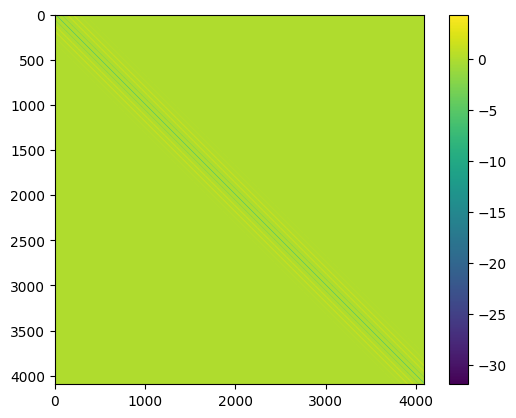

In [78]:
#print(torch.allclose(L_oo,L_oo_vec))
print(L_oo.shape)
plt.imshow(L_oo)
plt.colorbar()

In [79]:
import torch.optim as optim

def grad_loss(L,img,V):
    
    
    return torch.sqrt(torch.mean((torch.matmul(L,img)-V)**2))


def fit(L,V):
    optimizer=optim.LBFGS([torch.zeros(0)],lr=1e-2, max_iter=1000)
    eps_b=V.clone()#torch.randn(V.shape)
    eps_b.requires_grad = True
    optimizer.param_groups[0]['params'][0] = eps_b

    def closure():
        optimizer.zero_grad()
        loss=grad_loss(L,eps_b,V)
        loss.backward(retain_graph=True)
        return loss
    loss=optimizer.step(closure)
    print(loss)
    
    return eps_b

eps=fit(L_oo,V_o)

eps=eps.detach()
print(eps.shape)

tensor(0.3353, grad_fn=<SqrtBackward0>)
torch.Size([4096])


In [80]:
#grid resolution
n_p=128

min_x=bord[0].item()
max_x=bord[1].item()
min_y=bord[2].item()
max_y=bord[3].item()

width_x=max_x-min_x
width_y=max_y-min_y

image_res=torch.zeros((n_p,n_p))
vec=torch.linspace(min_x-width_x*0.125,max_x+width_x*0.125,n_p)


def get_X(x,l_g,q):
    res=torch.sum(torch.exp(-((q[0] - l_g[:,0])**2 + (q[1] - l_g[:,1])**2) / (l_g[0,2] * 2)**2)*x)

    return res
        





for i in range(len(vec)):
    for j in range(len(vec)):
        coords=torch.empty(2)
        coords[0]=vec[i]
        coords[1]=vec[j]
        image_res[i][j]=get_X(eps,L_gaussians,coords)

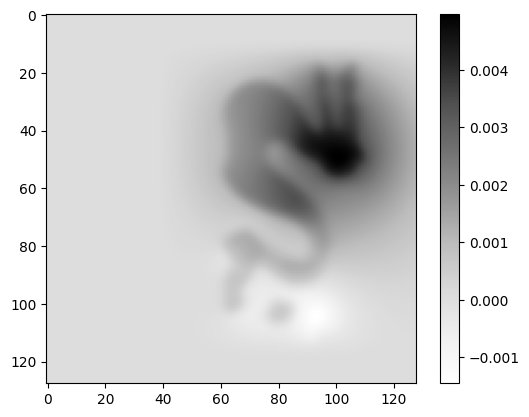

In [81]:
plt.imshow(image_res,cmap="Greys")
plt.colorbar()

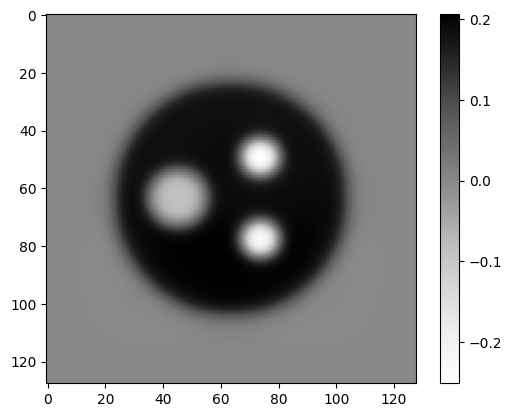

In [42]:
plt.imshow(image_res,cmap="Greys")
plt.colorbar()